In [1]:
using BenchmarkTools
using Unrolled

using SIMD

using ChipSort

In [6]:
sort_small_array(chunk::NTuple{L, Vec{N,T}}) where {L,N,T} =
    merge_vecs(transpose_vecs(sort_net(chunk...)...)...)

function sort_chunks(output, data::Array{T, 1}, ::Val{L}, ::Val{N}) where {L,N,T}
    chunk_size = N*L
    num_chunks = div(length(data), chunk_size)

    for m in 1:num_chunks
        chunk = ntuple(l->vload(Vec{N, T}, data, 1 + (m-1)*chunk_size + (l-1)*N), L)
        sorted_chunk = sort_small_array(chunk)
        vstorent(sorted_chunk, output, 1 + (m-1)*(N*L))
    end
    output
end

function chipsort_2st(data::Array{T, 1}, ::Val{N}, ::Val{L}, ::Val{N2}) where {T, N, L, N2}
    chunk_size = L * N
    Nchunks = div(size(data, 1), chunk_size)
    output1 = valloc(T, div(32, sizeof(T)), length(data))
    output2 = valloc(T, div(32, sizeof(T)), length(data))
    #output2[:] .= 0

    sort_chunks(output1, data, Val(L), Val(N))
    
    chunk1 = @view output1[1:chunk_size]
    chunk2 = @view output1[1+chunk_size:end]
    
    h1 = vload(Vec{N, T}, chunk1, 1)
    h2 = vload(Vec{N, T}, chunk2, 1)
    a,state = bitonic_merge(h1,h2)
    vstorent(a, output2, 1)
    h1 = vload(Vec{N, T}, chunk1, 1+N)
    h2 = vload(Vec{N, T}, chunk2, 1+N)

    if h1[1] < h2[1]
        a, state = bitonic_merge(state, h1)
        vstorent(a, output2, 1+1*N)
        a, state = bitonic_merge(state, h2)
        vstorent(a, output2, 1+2*N)
        vstorent(state, output2, 1+3*N)
    else
        a, state = bitonic_merge(state, h2)
        vstorent(a, output2, 1+1*N)
        a, state = bitonic_merge(state, h1)
        vstorent(a, output2, 1+2*N)
        vstorent(state, output2, 1+3*N)
    end            
    output2
end
data=rand(Int8,16)
sort(data)[1:16]'

1×16 LinearAlgebra.Adjoint{Int8,Array{Int8,1}}:
 -124  -96  -87  -87  -68  -43  -42  -30  -9  -2  3  15  20  20  103  106

In [7]:
chipsort_2st(data, Val(4), Val(2))[:]'

1×16 LinearAlgebra.Adjoint{Int8,Array{Int8,1}}:
 -124  -96  -87  -87  -68  -43  -42  -30  -9  -2  3  15  20  20  103  106

In [8]:
function run_bench_mine(T, data_size, ::Val{N}, ::Val{L}) where {N, L}
    data = rand(T, data_size)

    #stat = @benchmark chipsort($data, Val($N), Val($L), Val($N))
    stat = @benchmark chipsort_2st($data, Val($N), Val($L))
    stat
end

function run_bench_base(T, data_size, ::Val{N}, ::Val{L}) where {N, L}
    data = rand(T, data_size)

    stat = @benchmark sort($data)
    stat
end

run_bench_base (generic function with 1 method)

In [27]:
N = Val(4)

struct ExpRun
    code
    eltype
    data_size
    vec_size
    vec_count
    bench
end

function Base.show(io::IO, ee::ExpRun)
    print(ee.code, " ")
    print(ee.eltype, " ")
    print(ee.data_size, " ")
    print(ee.vec_size, " ")
    print(ee.vec_count, " ")
    print(ee.bench.times[div(end,2)])
end

@unroll function run_tests(nn,ll)
    exps = ExpRun[]

    T = Float32
    @unroll for n in nn
        @unroll for l in ll
            data_size = n*l*2
            tt = run_bench_mine(T, data_size, Val(n), Val(l))
            ee = ExpRun(:chip, T, data_size, n, l, tt)
            println(ee)
            push!(exps, ee)
            tt = run_bench_base(T, data_size, Val(n), Val(l))
            ee = ExpRun(:juli, T, data_size, n, l, tt)
            println(ee)
            push!(exps, ee)
        end
    end
    exps
end

data = run_tests((4,8,16), (2,))

chip Float32 16 4 2 6201.8
juli Float32 16 4 2 100.89563365282216
chip Float32 32 8 2 6660.8
juli Float32 32 8 2 189.515243902439
chip Float32 64 16 2 6361.8
juli Float32 64 16 2 381.8333333333333
chip Float32 16 4 2 6201.8juli Float32 16 4 2 100.89563365282216chip Float32 32 8 2 6660.8juli Float32 32 8 2 189.515243902439chip Float32 64 16 2 6361.8juli Float32 64 16 2 381.8333333333333

6-element Array{ExpRun,1}:
 
 
 
 
 
 

chip Float32 16 4 2 6201.8chip Float32 16 4 2 6201.8juli Float32 16 4 2 100.89563365282216juli Float32 16 4 2 100.89563365282216chip Float32 32 8 2 6660.8chip Float32 32 8 2 6660.8juli Float32 32 8 2 189.515243902439juli Float32 32 8 2 189.515243902439chip Float32 64 16 2 6361.8chip Float32 64 16 2 6361.8juli Float32 64 16 2 381.8333333333333juli Float32 64 16 2 381.8333333333333

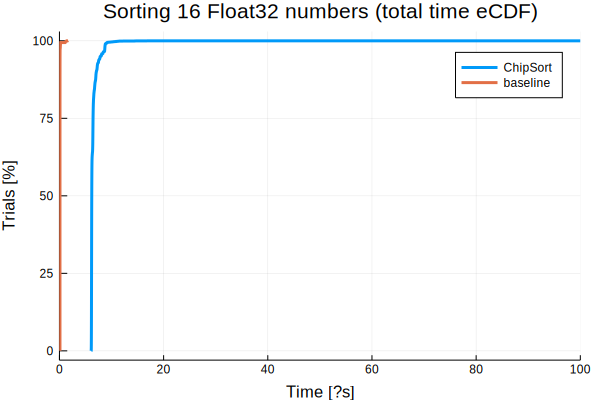

In [28]:
using Plots
plot(xlim=(0, 100),
     xlabel="Time [μs]", ylabel="Trials [%]", title="Sorting 16 Float32 numbers (total time eCDF)")
plot!(data[1].bench.times*1e-3, 1e-2.*(1:10000), l=3, label="ChipSort")
plot!(data[2].bench.times*1e-3, 1e-2.*(1:10000), l=3, label="baseline")

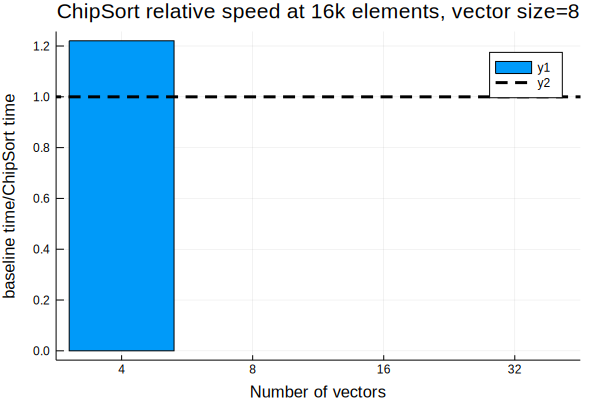

In [26]:
ch = [ee.bench.times[div(end,2)] for ee in data if ee.vec_size == 4 && ee.code==:chip]
jj = [ee.bench.times[div(end,2)] for ee in data if ee.vec_size == 4 && ee.code==:juli]

plot(xticks=(1:4, [4,8,16,32]), title="ChipSort relative speed at 16k elements, vector size=8", xlabel="Number of vectors",
     xlim=(0.5,4.5), ylabel=("baseline time/ChipSort time"))
bar!(jj./ch)
plot!([0,5],[1,1],ls=:dash, color=:black, l=3)